# Wahidul Alam  
## Project: Classification using SVM 
## Date of submission: 12/07/2020

### importing all the necessary libraries together

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
import warnings; warnings.simplefilter('ignore')
from scipy import ndimage
import cv2
from skimage.transform import resize
from scipy.stats import kurtosis
from scipy.stats import skew
from skimage.feature import hog
from skimage import data, exposure
import skimage.measure
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
 

# Loading CIFAR-10 Data
#### The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images 
#### per class. There are 50000 training images and 10000 test images.

In [2]:
(x_train1, y_train), (x_test1, y_test) = tf.keras.datasets.cifar10.load_data()

x_train=np.dot(x_train1[...,:3], [0.299, 0.587, 0.114])
x_test=np.dot(x_test1[...,:3], [0.299, 0.587, 0.114])

xtrain=np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
xtest=np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))

ntrain=50000
ntest=10000
xtrainA=xtrain[0:ntrain]
xtrain=xtrain[0:ntrain]

y_train=y_train[0:ntrain]

xtest=xtest[0:ntest]
y_test=y_test[0:ntest]

ytrain=y_train.flatten()
ytest=y_test.flatten()

target_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Comments:
#### Here, I have converted the images into grayscale.  

# feature extraction and visualization for PCA
#### PCA (principal component analysis) is a method of dimentionality reduction to reduce the dimension of larger dataset into a compressed one which contains the most of the necessary information to build an efficient model.

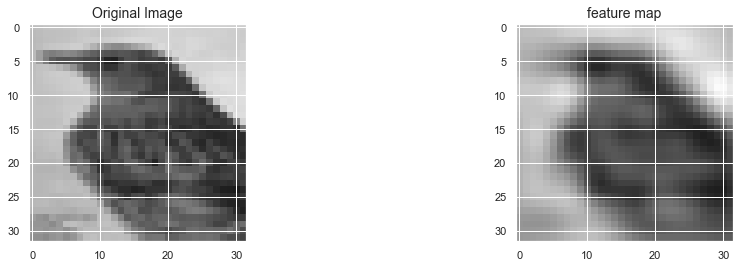

In [3]:
## PCA components extraction

scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)
pca = PCA(0.9)
pca.fit(xtrain)
train_img_pca = pca.transform(xtrain)
test_img_pca = pca.transform(xtest)


## PCA visalization
res_train_img = pca.inverse_transform(train_img_pca)
res_train_img = scaler.inverse_transform(res_train_img)


plt.figure(figsize=(16,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(xtrainA[18].reshape(32,32),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('Original Image', fontsize = 14);

plt.subplot(1, 2, 2);
plt.imshow(res_train_img[18].reshape(32, 32),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('feature map', fontsize = 14);

## model fitting for PCA with best parameters (c & gamma) estimation

In [4]:
start = time.process_time()
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(svc)
param_grid = {'svc__C': [2, 3, 4, 5],
              #'svc__C': [1, 5, 10, 20],
              #'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
              'svc__gamma': [0.0002, 0.0003, 0.0004, 0.0005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(train_img_pca , ytrain)

model = grid.best_estimator_

print((time.process_time()-start)/60)
print(grid.best_params_)

CPU times: user 2h 44min 50s, sys: 13.6 s, total: 2h 45min 4s
Wall time: 2h 45min 5s
329.6838752
{'svc__C': 5, 'svc__gamma': 0.0005}


# Comments:
#### From the grid search for the (C & gamma), we got our best estimator for C=5 and gamma= 0.005. For rest of the process, we will fix the parameters to these values and fit the model for additional features. 

## result from model fitting based on PCA feature

100%|██████████| 50000/50000 [00:00<00:00, 1514014.27it/s]


7.31589070000003
Train accuracy: 0.597


100%|██████████| 10000/10000 [00:00<00:00, 397202.92it/s]


1.4653062000000014
Test accuracy: 0.462
              precision    recall  f1-score   support

    Airplane       0.49      0.44      0.46      1000
  Automobile       0.58      0.56      0.57      1000
        Bird       0.33      0.34      0.34      1000
         Cat       0.35      0.29      0.32      1000
        Deer       0.36      0.44      0.39      1000
         Dog       0.49      0.37      0.42      1000
        Frog       0.44      0.55      0.49      1000
       Horse       0.59      0.49      0.53      1000
        Ship       0.52      0.60      0.56      1000
       Truck       0.53      0.54      0.53      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.46     10000
weighted avg       0.47      0.46      0.46     10000

Micro-averaged precision = 0.46 (treat instances equally)
Macro-averaged precision = 0.47 (treat classes equally)


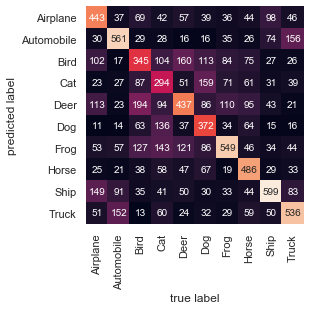

In [5]:
## obtaing training accuracy
start = time.process_time()
ypred=model.predict(train_img_pca)
accuracy=[]
for i in tqdm(range(ytrain.shape[0])):
    if ypred[i]==ytrain[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Train accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtrain.shape[0]))))


## obtaing test accuracy
start = time.process_time()
ypred=model.predict(test_img_pca)
accuracy=[]
for i in tqdm(range(ytest.shape[0])):
    if ypred[i]==ytest[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Test accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtest.shape[0]))))



## obtaing confusion matrix accuracy
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');




## obtaing classification report
print(classification_report(ytest, ypred, target_names=target_names))
print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(ytest, ypred, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(ytest, ypred, average = 'macro')))

# Comments on score from PCA feature extraction:
#### As I have mentioned before PCA feature extraction, it is shown that PCA helped the model to improve efficiency; thereby, model classified the training and test data with 59.7% and 46.2% accuracy. PCA feature map of a sample is shown above to appreciate the strenth of the PCA dimention reduction.

# feature extraction and visualization for FFT
#### It is well known that convolution of filters in the image domain become multiplication in the frequency domain. Moreover, frequency infomation of an image is unique to that image. This reduncy is helpful to estimate the model paramters more efficiently

100%|██████████| 10000/10000 [00:00<00:00, 16267.68it/s]


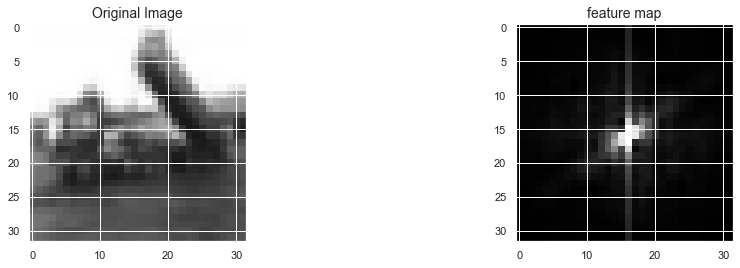

In [6]:
xtrain_fft=np.zeros_like(xtrain)
xtest_fft=np.zeros_like(xtest)

for i in tqdm(range(ytrain.shape[0])):
    xtrain_fft[i]=np.reshape(np.abs(np.fft.fftshift(np.fft.fft2(xtrain[i].reshape(32,32)))),(1,1024))
for i in tqdm(range(ytest.shape[0])):
    xtest_fft[i]=np.reshape(np.abs(np.fft.fftshift(np.fft.fft2(xtest[i].reshape(32,32)))),(1,1024))


import warnings; warnings.simplefilter('ignore')
scaler = StandardScaler()
scaler.fit(xtrain_fft)
xtrain_fft = scaler.transform(xtrain_fft)
xtest_fft = scaler.transform(xtest_fft)


pca_fft = PCA(0.54)
pca_fft.fit(xtrain_fft)
pca_train_img_fft = pca_fft.transform(xtrain_fft)
pca_test_img_fft = pca_fft.transform(xtest_fft)

train_img_pca_fft=np.concatenate((train_img_pca, pca_train_img_fft), axis=1)
test_img_pca_fft=np.concatenate((test_img_pca, pca_test_img_fft), axis=1)


## Visualization for FFT
res_train_img = pca_fft.inverse_transform(pca_train_img_fft)
res_train_img = scaler.inverse_transform(res_train_img)
plt.figure(figsize=(16,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(xtrainA[2].reshape(32,32),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('Original Image', fontsize = 14);

plt.subplot(1, 2, 2);
plt.imshow(res_train_img[2].reshape(32, 32),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.title('feature map', fontsize = 14);


#  result from model fitting based on (PCA+FFT) feature

CPU times: user 27min 1s, sys: 1.36 s, total: 27min 2s
Wall time: 27min 3s
54.05344126666666
{'svc__C': 5, 'svc__gamma': 0.0005}


100%|██████████| 50000/50000 [00:00<00:00, 1383902.49it/s]


15.702817766666643
Train accuracy: 0.855


100%|██████████| 10000/10000 [00:00<00:00, 391022.61it/s]


3.142338533333289
Test accuracy: 0.566
              precision    recall  f1-score   support

    Airplane       0.58      0.58      0.58      1000
  Automobile       0.62      0.65      0.63      1000
        Bird       0.45      0.46      0.45      1000
         Cat       0.39      0.37      0.38      1000
        Deer       0.51      0.52      0.51      1000
         Dog       0.50      0.50      0.50      1000
        Frog       0.64      0.66      0.65      1000
       Horse       0.65      0.57      0.61      1000
        Ship       0.66      0.68      0.67      1000
       Truck       0.65      0.68      0.66      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

Micro-averaged precision = 0.57 (treat instances equally)
Macro-averaged precision = 0.57 (treat classes equally)


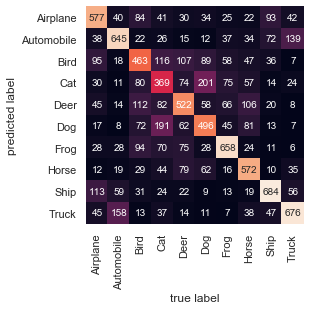

In [7]:
start = time.process_time()
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(svc)


param_grid = {'svc__C': [5],
              #'svc__C': [1, 5, 10, 20],
              #'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
              'svc__gamma': [0.0005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(train_img_pca_fft , ytrain)

model = grid.best_estimator_

print((time.process_time()-start)/60)
print(grid.best_params_)




## obtaing training accuracy
 
start = time.process_time()
ypred=model.predict(train_img_pca_fft)
accuracy=[]
for i in tqdm(range(ytrain.shape[0])):
    if ypred[i]==ytrain[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Train accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtrain.shape[0]))))


## obtaing test accuracy
import time
start = time.process_time()
ypred=model.predict(test_img_pca_fft)
accuracy=[]
for i in tqdm(range(ytest.shape[0])):
    if ypred[i]==ytest[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Test accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtest.shape[0]))))



## obtaing confusion matrix accuracy
 
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');




## obtaing classification report
 
print(classification_report(ytest, ypred, target_names=target_names))

 
print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(ytest, ypred, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(ytest, ypred, average = 'macro')))

# Comments:
#### As expected, (training, test accuracy) has improved from (59.7%, 46.2%) to (85.5%,  56.6% )because of the combination of two strong features.

# feature extraction and visualization for LoG (Laplacian of Gaussian)
####  LoG is an isotropic meature of the second spatial derivative of the image. Therefore, it helps to detect the edge on the image.

100%|██████████| 10000/10000 [00:10<00:00, 960.96it/s]


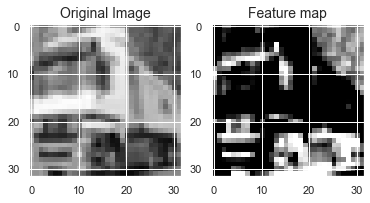

In [8]:
xtrain_log=np.zeros_like(xtrain)
xtest_log=np.zeros_like(xtest)

for i in tqdm(range(ytrain.shape[0])):
    xtrain_log[i]=np.reshape(ndimage.gaussian_laplace(np.reshape(xtrain[i],(32,32)), sigma=0.1),(1,1024))
for i in tqdm(range(ytest.shape[0])):
    xtest_log[i]=np.reshape(ndimage.gaussian_laplace(np.reshape(xtest[i],(32,32)), sigma=0.1),(1,1024)) 

n=32
LoG_train_img=np.zeros((xtrain_log.shape[0],n*n))
LoG_test_img=np.zeros((xtest_log.shape[0],n*n))

for i in range(xtrain_log.shape[0]):
    LoG_train_img[i] = cv2.resize(xtrain_log[i].reshape(32,32), dsize=(n,n), interpolation=cv2.INTER_CUBIC).reshape(1,n*n)
for i in range(xtest_log.shape[0]):
    LoG_test_img[i] = cv2.resize(xtest_log[i].reshape(32,32), dsize=(n,n), interpolation=cv2.INTER_CUBIC).reshape(1,n*n)

# Original Image
plt.subplot(121);
plt.imshow(xtrainA[1].reshape(32,32), cmap = plt.cm.gray, interpolation='nearest', clim=(0, 255))
plt.title('Original Image', fontsize = 14);
# PCA of Feature
plt.subplot(122);
plt.imshow(LoG_train_img[1].reshape(n, n), cmap = plt.cm.gray, interpolation='nearest', clim=(0, 255))
plt.title('Feature map', fontsize = 14);

train_img_pca_fft_log=np.concatenate((train_img_pca_fft, LoG_train_img), axis=1)
test_img_pca_fft_log=np.concatenate(( test_img_pca_fft, LoG_test_img), axis=1)

#  result from model fitting based on (PCA+FFT+LoG) feature

CPU times: user 4h 56min 29s, sys: 8.74 s, total: 4h 56min 38s
Wall time: 4h 56min 40s
592.9990310000001
{'svc__C': 5, 'svc__gamma': 0.0005}


100%|██████████| 50000/50000 [00:00<00:00, 1456962.62it/s]


117.06953216666662
Train accuracy: 1.000


100%|██████████| 10000/10000 [00:00<00:00, 396399.58it/s]


23.415169466666704
Test accuracy: 0.100
              precision    recall  f1-score   support

    Airplane       0.00      0.00      0.00      1000
  Automobile       1.00      0.00      0.00      1000
        Bird       0.00      0.00      0.00      1000
         Cat       1.00      0.00      0.00      1000
        Deer       0.00      0.00      0.00      1000
         Dog       0.00      0.00      0.00      1000
        Frog       0.00      0.00      0.00      1000
       Horse       1.00      0.00      0.00      1000
        Ship       0.00      0.00      0.00      1000
       Truck       0.10      1.00      0.18      1000

    accuracy                           0.10     10000
   macro avg       0.31      0.10      0.02     10000
weighted avg       0.31      0.10      0.02     10000

Micro-averaged precision = 0.10 (treat instances equally)
Macro-averaged precision = 0.31 (treat classes equally)


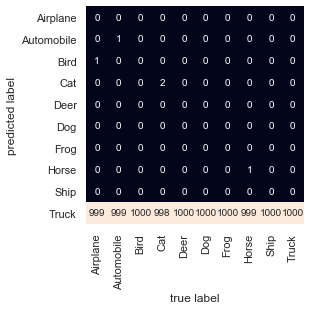

In [9]:
 
start = time.process_time()
 
from sklearn.model_selection import GridSearchCV

svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(svc)


param_grid = {'svc__C': [5],
              #'svc__C': [1, 5, 10, 20],
              #'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
              'svc__gamma': [0.0005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(train_img_pca_fft_log , ytrain)

model = grid.best_estimator_

print((time.process_time()-start)/60)
print(grid.best_params_)




## obtaing training accuracy
start = time.process_time()
ypred=model.predict(train_img_pca_fft_log)
accuracy=[]
for i in tqdm(range(ytrain.shape[0])):
    if ypred[i]==ytrain[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Train accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtrain.shape[0]))))


## obtaing test accuracy
start = time.process_time()
ypred=model.predict(test_img_pca_fft_log)
accuracy=[]
for i in tqdm(range(ytest.shape[0])):
    if ypred[i]==ytest[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Test accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtest.shape[0]))))



## obtaing confusion matrix accuracy
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');




## obtaing classification report
print(classification_report(ytest, ypred, target_names=target_names))

print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(ytest, ypred, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(ytest, ypred, average = 'macro')))

# Comments:
#### For my case, LoG was not helpful enough. One possible reason could be the noise in the image which misled the laplacian filter.  Therefore, it will not be considered into model fitting.

# feature extraction for Kurtosis & Skew
#### skewness measure the lack of symmetry and kurtosis measures tailness of the image relative to a normal distribution. From definition, it can be realized, how useful these features can be!

In [10]:
xtrain_ks=np.zeros((xtrain.shape[0],2))
xtest_ks=np.zeros((xtest.shape[0],2))

for i in tqdm(range(ytrain.shape[0])):
    xtrain_ks[i,0]=kurtosis(xtrain[i])
    xtrain_ks[i,1]=skew(xtrain[i])
for i in tqdm(range(ytest.shape[0])):
    xtest_ks[i,0]=kurtosis(xtest[i])
    xtest_ks[i,1]=skew(xtest[i])
    
train_img_pca_fft_ks=np.concatenate((train_img_pca_fft, xtrain_ks), axis=1)
test_img_pca_fft_ks=np.concatenate((test_img_pca_fft, xtest_ks), axis=1)

100%|██████████| 10000/10000 [00:02<00:00, 3442.36it/s]


#  result from model fitting based on (PCA+FFT+Kurtosis & Skew) feature

CPU times: user 27min 16s, sys: 1.2 s, total: 27min 17s
Wall time: 27min 17s
54.55518396666666
{'svc__C': 5, 'svc__gamma': 0.0005}


100%|██████████| 50000/50000 [00:00<00:00, 1484425.63it/s]


16.10893670000005
Train accuracy: 0.858


100%|██████████| 10000/10000 [00:00<00:00, 401426.42it/s]


3.2215648666666916
Test accuracy: 0.567
              precision    recall  f1-score   support

    Airplane       0.58      0.58      0.58      1000
  Automobile       0.62      0.64      0.63      1000
        Bird       0.45      0.46      0.45      1000
         Cat       0.40      0.38      0.39      1000
        Deer       0.50      0.52      0.51      1000
         Dog       0.50      0.50      0.50      1000
        Frog       0.65      0.65      0.65      1000
       Horse       0.66      0.58      0.62      1000
        Ship       0.67      0.69      0.67      1000
       Truck       0.65      0.68      0.66      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000

Micro-averaged precision = 0.57 (treat instances equally)
Macro-averaged precision = 0.57 (treat classes equally)


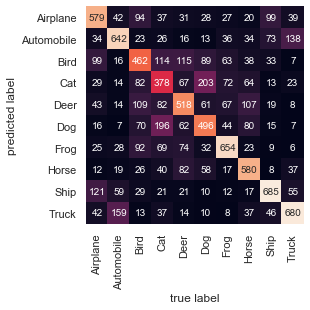

In [11]:
start = time.process_time() 
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(svc)


param_grid = {'svc__C': [5],
              #'svc__C': [1, 5, 10, 20],
              #'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
              'svc__gamma': [0.0005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(train_img_pca_fft_ks , ytrain)

model = grid.best_estimator_

print((time.process_time()-start)/60)
print(grid.best_params_)




## obtaing training accuracy
 
start = time.process_time()
ypred=model.predict(train_img_pca_fft_ks)
accuracy=[]
for i in tqdm(range(ytrain.shape[0])):
    if ypred[i]==ytrain[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Train accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtrain.shape[0]))))


## obtaing test accuracy
 
start = time.process_time()
ypred=model.predict(test_img_pca_fft_ks)
accuracy=[]
for i in tqdm(range(ytest.shape[0])):
    if ypred[i]==ytest[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Test accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtest.shape[0]))))



## obtaing confusion matrix accuracy
 
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');




## obtaing classification report
 
print(classification_report(ytest, ypred, target_names=target_names))

 
print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(ytest, ypred, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(ytest, ypred, average = 'macro')))

####  (training, test accuracy) has improved from (85.5%,  56.6%) to (85.8%,  56.7% ).

# feature extraction for HOG (histogram of Oriented Gradients)
### One of the widely used feature descriptor to extract the gradient and orientation of the of the edges in images. Therefore, efficiency is expected to be improved with conjuction of other three features

In [12]:
 
xtrain_hog=np.zeros_like(xtrain)
xtest_hog=np.zeros_like(xtest)

for i in tqdm(range(ytrain.shape[0])):
    _, hog_image_train = hog(np.reshape(xtrain[i],(32,32)), pixels_per_cell=(2, 2), visualize=True)
    xtrain_hog[i]=np.reshape(hog_image_train,(1,1024))
for i in tqdm(range(ytest.shape[0])):
    _, hog_image_test = hog(np.reshape(xtest[i],(32,32)), pixels_per_cell=(2, 2), visualize=True)
    xtest_hog[i]=np.reshape(hog_image_test,(1,1024))

from sklearn.preprocessing import StandardScaler
import warnings; warnings.simplefilter('ignore')
scaler = StandardScaler()
scaler.fit(xtrain_hog)
xtrain_hog = scaler.transform(xtrain_hog)
xtest_hog = scaler.transform(xtest_hog)

 
pca_hog = PCA(0.95)
pca_hog.fit(xtrain_hog)
pca_train_img_hog = pca_hog.transform(xtrain_hog)
pca_test_img_hog = pca_hog.transform(xtest_hog)

train_img_pca_fft_ks_hog=np.concatenate((train_img_pca_fft_ks, pca_train_img_hog), axis=1)
test_img_pca_fft_ks_hog=np.concatenate((test_img_pca_fft_ks, pca_test_img_hog), axis=1)

100%|██████████| 10000/10000 [06:40<00:00, 24.96it/s]


# result from model fitting based on (PCA+FFT+ks+HoG) feature

CPU times: user 53min, sys: 2.17 s, total: 53min 2s
Wall time: 53min 3s
106.02163886666652
{'svc__C': 5, 'svc__gamma': 0.0005}


100%|██████████| 50000/50000 [00:00<00:00, 1392022.83it/s]


31.650764166666583
Train accuracy: 0.935


100%|██████████| 10000/10000 [00:00<00:00, 351641.04it/s]


6.330492033333333
Test accuracy: 0.611
              precision    recall  f1-score   support

    Airplane       0.63      0.66      0.65      1000
  Automobile       0.67      0.70      0.68      1000
        Bird       0.49      0.49      0.49      1000
         Cat       0.43      0.41      0.42      1000
        Deer       0.56      0.57      0.57      1000
         Dog       0.54      0.52      0.53      1000
        Frog       0.68      0.72      0.70      1000
       Horse       0.69      0.62      0.66      1000
        Ship       0.72      0.72      0.72      1000
       Truck       0.68      0.69      0.69      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000

Micro-averaged precision = 0.61 (treat instances equally)
Macro-averaged precision = 0.61 (treat classes equally)


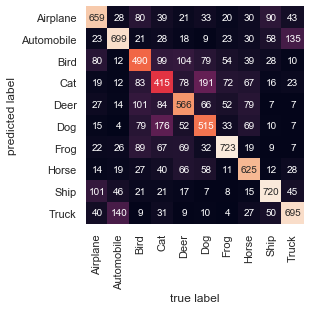

In [13]:
 
start = time.process_time()
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(svc)


param_grid = {'svc__C': [5],
              #'svc__C': [1, 5, 10, 20],
              #'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
              'svc__gamma': [0.0005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(train_img_pca_fft_ks_hog , ytrain)

model = grid.best_estimator_

print((time.process_time()-start)/60)
print(grid.best_params_)




## obtaing training accuracy
 
start = time.process_time()
ypred=model.predict(train_img_pca_fft_ks_hog)
accuracy=[]
for i in tqdm(range(ytrain.shape[0])):
    if ypred[i]==ytrain[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Train accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtrain.shape[0]))))


## obtaing test accuracy
 
start = time.process_time()
ypred=model.predict(test_img_pca_fft_ks_hog)
accuracy=[]
for i in tqdm(range(ytest.shape[0])):
    if ypred[i]==ytest[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Test accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtest.shape[0]))))



## obtaing confusion matrix accuracy
 
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');




## obtaing classification report
 
print(classification_report(ytest, ypred, target_names=target_names))

 
print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(ytest, ypred, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(ytest, ypred, average = 'macro')))

# Comments:
#### addition of LOG into the feature extraction pool fitted the model better and thereby efficiency is increased from (85.8%,  56.7% ) to (93.5%,  61.1%).

# feature extraction for  Entropy
### entropy meatures the randomness in the image

In [14]:
xtrain_Entropy=np.zeros((xtrain.shape[0],1))
xtest_Entropy=np.zeros((xtest.shape[0],1))

for i in tqdm(range(ytrain.shape[0])):
    xtrain_Entropy[i] = skimage.measure.shannon_entropy(xtrain[i])

for i in tqdm(range(ytest.shape[0])):
    xtest_Entropy[i] = skimage.measure.shannon_entropy(xtest[i])

train_img_pca_fft_ks_hog_entropy = np.concatenate((train_img_pca_fft_ks_hog,xtrain_Entropy), axis=1)
test_img_pca_fft_ks_hog_entropy = np.concatenate((test_img_pca_fft_ks_hog,xtest_Entropy), axis=1)

100%|██████████| 10000/10000 [00:00<00:00, 11355.66it/s]


# result from model fitting based on (PCA+FFT+ks+HoG+entropy) features

CPU times: user 53min 6s, sys: 1.94 s, total: 53min 8s
Wall time: 53min 8s
106.22822916666652
{'svc__C': 5, 'svc__gamma': 0.0005}


100%|██████████| 50000/50000 [00:00<00:00, 1493474.62it/s]


31.789679866666607
Train accuracy: 0.935


100%|██████████| 10000/10000 [00:00<00:00, 390440.21it/s]


6.360528066666787
Test accuracy: 0.611
              precision    recall  f1-score   support

    Airplane       0.63      0.66      0.65      1000
  Automobile       0.67      0.70      0.68      1000
        Bird       0.49      0.49      0.49      1000
         Cat       0.43      0.41      0.42      1000
        Deer       0.56      0.57      0.57      1000
         Dog       0.54      0.52      0.53      1000
        Frog       0.68      0.72      0.70      1000
       Horse       0.69      0.62      0.66      1000
        Ship       0.72      0.72      0.72      1000
       Truck       0.68      0.69      0.69      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000

Micro-averaged precision = 0.61 (treat instances equally)
Macro-averaged precision = 0.61 (treat classes equally)


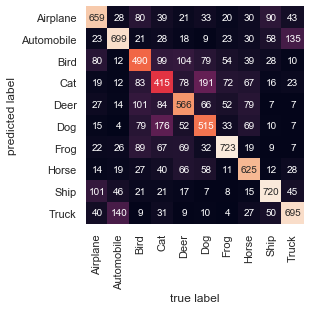

In [15]:
start = time.process_time()
#pca = RandomizedPCA(n_components=462)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(svc)


param_grid = {'svc__C': [5],
              #'svc__C': [1, 5, 10, 20],
              #'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
              'svc__gamma': [0.0005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(train_img_pca_fft_ks_hog_entropy , ytrain)

model = grid.best_estimator_

print((time.process_time()-start)/60)
print(grid.best_params_)




## obtaing training accuracy

start = time.process_time()
ypred=model.predict(train_img_pca_fft_ks_hog_entropy)
accuracy=[]
for i in tqdm(range(ytrain.shape[0])):
    if ypred[i]==ytrain[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Train accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtrain.shape[0]))))


## obtaing test accuracy
start = time.process_time()
ypred=model.predict(test_img_pca_fft_ks_hog_entropy)
accuracy=[]
for i in tqdm(range(ytest.shape[0])):
    if ypred[i]==ytest[i]:
        accuracy.append(1)
print((time.process_time()-start)/60)
print(str('Test accuracy: {:0.3f}'.format(sum(accuracy)/np.sum(xtest.shape[0]))))



## obtaing confusion matrix accuracy
 
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');




## obtaing classification report
 
print(classification_report(ytest, ypred, target_names=target_names))

 
print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(ytest, ypred, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(ytest, ypred, average = 'macro')))

## Final comments: 
#### addition of information from entropy did not help much. Therefore, it was shown that PCA, FFT, and HOG were three significant feature vector to fit model efficiently. There could be some other significant feature which I have plan to explore once I manage to. Moreover, from the classification report, it is seen that the test data are balanced, which is why the support vectors for all of the classes are same.